In [ ]:
cd /data/cilia/notebooks

In [40]:
from __future__ import print_function
from builtins import range
import pandas as pd
import numpy as np
import os, glob, random, math
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [3]:
labels_path = '../input/labels.txt'
labels = pd.read_table(labels_path, sep=' ', names=['Patient', 'Abnormality', 'class'])

In [4]:
labels.groupby('class').count()

,Patient,Abnormality
class,,
0,96,96
1,53,53


In [5]:
labels.groupby('Abnormality').count()

,Patient,class
Abnormality,,
1,82,82
2,14,14
3,13,13
4,40,40


In [6]:
missing = 0
for file in os.listdir('../input/rotation'):
    patient = file[:4]
    if labels.loc[labels['Patient'] == int(patient)].shape[0] == 0:
        print('Missing:', file)
        missing += 1
    elif '-' in file:
        print(patient + file[4:])
    else:
        print(patient + '-' + file[4:])
print('Total missing labels: ', missing)

('Missing:', '9050l.npy')
7246-4.npy
1015-2.npy
7152-13.npy
7269-2.npy
7019-17.npy
1055-6.npy
1031-3.npy
7016-6.npy
9022-2.npy
7235-7.npy
9031-13.npy
7318-12.npy
9051-s.npy
('Missing:', '9048j.npy')
('Missing:', '90346.npy')
1015-5.npy
9051-w.npy
9045-k.npy
7318-3.npy
7160-10.npy
1033-3.npy
9043-i.npy
7027-7.npy
1028-5.npy
9003-1c200.npy
7261-10.npy
9020-1f.npy
7027-5.npy
9049-n.npy
1038-1.npy
1028-3.npy
9019-8.npy
9023-4.npy
7019-6.npy
9013-l.npy
7318-2.npy
7246-12.npy
1043-2.npy
7246-2.npy
9036-14.npy
9025-3.npy
1045-8.npy
7281-6.npy
9013-s.npy
9043-k.npy
1045-10.npy
1006-7.npy
9035-11.npy
9043-e.npy
1055-3.npy
9033-11.npy
7208-12.npy
9024-2.npy
9044-g.npy
9049-t.npy
7235-3.npy
1001-1.npy
7016-4.npy
9049-q.npy
7016-1.npy
9013-u.npy
9051-b.npy
7132-20.npy
1043-8.npy
9049-s.npy
7241-12.npy
7096-10.npy
1034-9.npy
('Missing:', '90348.npy')
7016-3.npy
('Missing:', '90347.npy')
9028-4.npy
1031-1.npy
7286-9.npy
1036-7.npy
7050-4.npy
9023-1.npy
7127-16.npy
7318-5.npy
7318-7.npy
9033-8.npy
70

In [7]:
rota = np.load('../input/rotation/1001-1.npy')

In [8]:
rota.shape

(250, 480, 640)

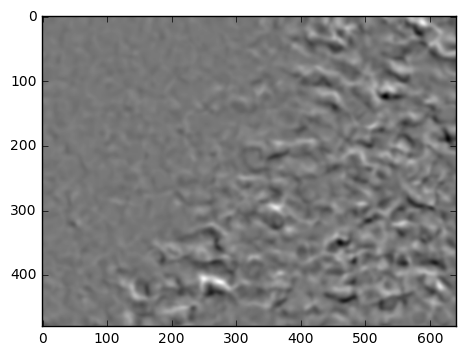

In [15]:
plt.imshow(rota[150], cmap='gray')
plt.show()

In [75]:
def get_blocks(lis, n):
    for i in range(0, len(lis), n):
        yield lis[i:i + int(n)]

def mean(lis):
    return sum(lis) / len(lis)

def preprocess_data(vid, labels, y_img_size, x_img_size, block=20, visualize=False):
    patient = vid[:4]
    label_df = canonical.loc[canonical['Patient'] == int(patient)]
    label = label_df.iloc[0]['class']
    array = np.load('../input/rotation/' + vid)
    resized_array = [cv2.resize(frame, (y_img_size, x_img_size))
                     for frame in array]
    block_size = math.ceil(len(resized_array) / block)
    new_array = []
    for block_slice in get_blocks(resized_array, block_size):
        block_slice = list(map(mean, zip(*block_slice)))
        new_array.append(block_slice)
    if visualize:
        fig = plt.figure()
        for n, frame in enumerate(new_array):
            y = fig.add_subplot(4, 5, n + 1)
            y.imshow(frame, cmap='gray')
        plt.show()
    if label == 0: label = np.array([1,0])
    elif label == 1: label = np.array([0,1])
    return np.array(new_array), label

def name_format(name):
    if '-' in name:
        return name[:-4]
    else:
        return name[:4] + '-' + name[4:-4]

In [63]:
videos = os.listdir('../input/rotation')
labels = pd.read_table(labels_path, sep=' ',
                       names=['Patient', 'Abnormality', 'class'])

clean_labels = labels.drop_duplicates()

canonical_labels = clean_labels[(clean_labels['Abnormality'] == 4)
                          | (clean_labels['Abnormality'] == 1)]

canonical_labels.groupby('class').count()

,Patient,Abnormality
class,,
0,63,63
1,39,39


In [64]:
canon_arrays = []
num_canon = 0
abnormal = 0
normal = 0
total_files = len(os.listdir('../input/rotation'))
for file in os.listdir('../input/rotation'):
    patient = file[:4]
    row = canonical_labels.loc[canonical_labels['Patient'] == int(patient)]
    if row.shape[0] == 0:
        pass
    else:
        canon_arrays.append(file)
        num_canon += 1
        if(row['class'].values == 1): abnormal += 1
        else: normal += 1
print('Total canonical files: ', num_canon)
print('Total not canonical: ', total_files - num_canon)
print('Total valid abnormal files:', abnormal)
print('Total valid normal files: ', normal)
assert(len(canon_arrays) == normal + abnormal)

Total canonical files:  266
Total not canonical:  59
Total valid abnormal files: 127
Total valid normal files:  139


In [53]:
x_size = 120
y_size = 160
block = 20
save_path = '../input/rotation_resized_{}_{}_{}/'.format(y_size,
                                                         x_size,
                                                         block)
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [77]:
much_data = []
for n, vid in enumerate(canon_arrays):
    if n % 100 == 0:
        print(n)
    try:
        img_data, label = preprocess_data(vid, clean_labels, 
                                          y_img_size=y_size,
                                          x_img_size=x_size,
                                          block=block)
        much_data.append([img_data, label])
    except KeyError as e:
        print(str(e))
    file_path = save_path + '{}_{}_{}_{}.npy'.format(name_format(vid),
                                             y_size, 
                                             x_size,
                                             block)
    if not os.path.exists(file_path):
        np.save(file_path, much_data[n])

0
100
200


In [78]:
x_size = 120
y_size = 160
block = 20
n_classes = 2
batch_size = 2
dropout = 0.8
train_test_split = 0.5

In [79]:
x = tf.placeholder('float')
y = tf.placeholder('float')

In [85]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def max_pool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1],
                            strides=[1,2,2,2,1], padding='SAME')
def make_cnn(x):
    weights = {'W_conv1': tf.Variable(tf.random_normal([3,3,3,1,32])),
               'W_conv2': tf.Variable(tf.random_normal([3,3,3,32,64])),
               'W_fc': tf.Variable(tf.random_normal([386048, 1024])),
               'out': tf.Variable(tf.random_normal([1024, n_classes]))}
    
    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.reshape(x, shape=[-1, x_size, y_size, block, 1])
    
    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = max_pool3d(conv1)
    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = max_pool3d(conv2)
    
    fc = tf.reshape(conv2, [-1, 386048])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc']) + biases['b_fc'])
    fc = tf.nn.dropout(fc, dropout)
    
    output = tf.matmul(fc, weights['out']) + biases['out']
    return output

def train_cnn(x):
    y = tf.placeholder('float')
    predictions = make_cnn(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(predictions, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        successful_runs = 0
        total_runs = 0
        for epoch in range(epochs):
            epoch_loss = 0
            for data in train:
                total_runs += 1
                try:
                    x = data[0]
                    y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x:x, y:y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    print(str(e))
            print('Epoch', epoch+1, 'completed out of ', epochs, 'loss: ', epoch_loss)
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print('Accuracy: ', accuracy.eval({x:[i[0] for i in test],
                                               y:[i[1] for i in test]}))
        print('Done.')
        print('Accuracy: ', accuracy.eval({x:[i[0] for i in test],
                                           y:[i[1] for i in test]}))
        print('Number of successful runs: ', successful_runs/total_runs)


In [86]:
data_path = '../input/rotation_resized_120_160_20//'
rota_data = os.listdir(data_path)

In [87]:
random.seed(2017)
random.shuffle(rota_data)
split_point = int(round(train_test_split * len(rota_data)))
train = rota_data[:split_point]
test = rota_data[split_point:]

train_cnn(x)

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)